In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import os
import pandas as pd
import cv2

In [10]:
# --- Configuration ---
preprocessed_path = r'D:\FUCK!!\Pattern\Project\notebooks\new_preprocessed_RGB_images' # Make sure this path is correct
input_shape = (128, 128, 3)  # Standard VGG16 RGB input
batch_size = 64
num_epochs = 20 # Set a higher number of epochs, EarlyStopping will handle the actual stop

In [11]:
from tensorflow.keras.applications.resnet50 import preprocess_input

# “val_dir” is the root of your test/validation folder
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

print("Setting up Training Generator...")
train_generator = train_datagen.flow_from_directory(
    os.path.join(preprocessed_path, 'train'),
    target_size=input_shape[:2], # Use (224, 224)
    batch_size=batch_size,
    class_mode='sparse',         # Use sparse for sparse_categorical_crossentropy
    color_mode='rgb',
    shuffle=True             # Ensure images are loaded as RGB
)
print(f"Found {train_generator.samples} images belonging to {train_generator.num_classes} classes in training set.")

print("\nSetting up Validation Generator...")
val_generator = train_datagen.flow_from_directory(
    os.path.join(preprocessed_path, 'val'),
    target_size=input_shape[:2], # Use (224, 224)
    batch_size=batch_size,
    class_mode='sparse',         # Use sparse for sparse_categorical_crossentropy
    color_mode='rgb',            # Ensure images are loaded as RGB
    shuffle=False                # No need to shuffle validation data
)
print(f"Found {val_generator.samples} images belonging to {val_generator.num_classes} classes in validation set.")

print("\nSetting up Testing Generator...")
test_generator = train_datagen.flow_from_directory(
    r"D:\FUCK!!\Pattern\Project\notebooks\new_preprocessed_RGB_images\test",
    target_size=input_shape[:2], # Use (224, 224)
    batch_size=batch_size,
    class_mode='sparse',         # Use sparse for sparse_categorical_crossentropy
    color_mode='rgb',            # Ensure images are loaded as RGB
    shuffle=False                # No need to shuffle validation data
)
print(f"Found {test_generator.samples} images belonging to {test_generator.num_classes} classes in validation set.")


Setting up Training Generator...
Found 28400 images belonging to 10 classes.
Found 28400 images belonging to 10 classes in training set.

Setting up Validation Generator...
Found 497 images belonging to 10 classes.
Found 497 images belonging to 10 classes in validation set.

Setting up Testing Generator...
Found 268 images belonging to 10 classes.
Found 268 images belonging to 10 classes in validation set.


In [12]:
# Get the number of classes from the generator
num_classes = train_generator.num_classes
if num_classes != val_generator.num_classes:
    print("Warning: Training and validation sets have different numbers of classes!")


In [24]:
base = applications.ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape   
)

# 2) Freeze early blocks, fine-tune later ones
for layer in base.layers[:-6]:
    layer.trainable = False
print(f"VGG16 base model loaded. Trainable: {base.trainable}")


# Create the new model head
RN50_model = models.Sequential([
    base,
    layers.GlobalAveragePooling2D(name='global_avg_pool'),
    layers.Dense(512, activation='relu', name='fc1'),
    layers.BatchNormalization(),
    layers.Dropout(0.5, name='dropout_1'), # Dropout for regularization
    layers.Dense(256, activation='relu', name='fc2'),
    layers.BatchNormalization(),
    layers.Dropout(0.5, name='dropout_2'), # Dropout for regularization
    layers.Dense(128, activation='relu', name='fc3'),
    layers.BatchNormalization(),
    layers.Dropout(0.5, name='dropout_3'), # Dropout for regularization
    layers.Dense(num_classes, activation='softmax', name='predictions') # Output layer
], name="VGG16_Transfer_Learning")

# --- Compile Model ---
# Use Adam optimizer with a specific, smaller learning rate
optimizer = Adam(learning_rate=0.0001) # 0.0001 learning rate

RN50_model.compile(optimizer=optimizer,
                    loss='sparse_categorical_crossentropy', # Use sparse CE with class_mode='sparse'
                    metrics=['accuracy'])

print("\nModel Summary:")
RN50_model.summary()

VGG16 base model loaded. Trainable: True

Model Summary:


Model: "VGG16_Transfer_Learning"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc3 (Dense)                     │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,805,898 (94.63 MB)

 Trainable params: 2,272,138 (8.67 MB)

 Non-trainable params: 22,533,760 (85.96 MB)

In [26]:
# --- Define Callbacks ---
# Early stopping to prevent overfitting and stop training when val_loss stops improving
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    verbose=1,
    restore_best_weights=True # Restore model weights from the epoch with the best val_loss
)

# Model checkpoint to save the best model found during training
model_checkpoint = ModelCheckpoint(
    filepath='best_RN50_model.keras', # File path to save the model
    monitor='val_loss',
    save_best_only=True, # Only save a model if `val_loss` has improved
    verbose=1
)

In [ ]:
# --- Train the Model (Head Only) ---
print(f"\nStarting training for up to {num_epochs} epochs (head only)...")
history = RN50_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size, # Ensure steps cover the dataset
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size, # Ensure steps cover the dataset
    epochs=num_epochs,
    callbacks=[early_stopping, model_checkpoint] # Add the callbacks
)

print("\nTraining finished.")


Starting training for up to 20 epochs (head only)...
Epoch 1/20
434/443 ━━━━━━━━━━━━━━━━━━━━ 8s 889ms/step - accuracy: 0.2314 - loss: 2.7277

In [17]:
from tensorflow.keras.models import load_model
model = load_model(r'D:\FUCK!!\Pattern\Project\Models\best_vgg16_model.keras')

In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix

# 1) Prepare a “pure” test generator (no augmentation, only the same preprocessing)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_gen = test_datagen.flow_from_directory(
    directory=r'D:/FUCK!!/Pattern/Project/notebooks/new_preprocessed_RGB_images/test',    # point this to your test‐folder 
    target_size=input_shape[:2],           # e.g. (224, 224)
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False                           # important! so labels/preds align
)

Found 268 images belonging to 10 classes.


In [ ]:
# 0) Clear any old graphs / functions
tf.keras.backend.clear_session()

# 1) Reload your .keras model
model = load_model(r'D:\FUCK!!\Pattern\Project\Models\best_vgg16_model.keras')

# 2) Re-compile it with the correct loss and metrics, running eagerly
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
    run_eagerly=True    # ← this disables the tf.function wrapping
)

# 3) Now evaluate on your test generator (no need to pass steps)
loss, acc = model.evaluate(test_gen, verbose=1)
print(f"\nTest loss: {loss:.4f} — Test accuracy: {acc:.4f}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 860ms/step - accuracy: 0.7692 - loss: 0.6851

Test loss: 0.7752 — Test accuracy: 0.7463


In [ ]:
# 3) (Optional) Get per‐class metrics
#    - Predict class probabilities
steps = int(np.ceil(test_gen.samples / batch_size))
pred_probs = model.predict(
    test_gen,
    steps = steps,
    verbose=1
)
#    - Turn them into predicted class indices
pred_idxs = np.argmax(pred_probs, axis=1)
true_idxs = test_gen.classes
labels   = list(test_gen.class_indices.keys())

#    - Classification report
print("\nClassification Report:\n")
print(classification_report(true_idxs, pred_idxs, target_names=labels))



5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 799ms/step

Classification Report:

                                  precision    recall  f1-score   support

         Achaemenid architecture       0.88      0.93      0.90        40
American Foursquare architecture       0.83      0.68      0.75        37
        American craftsman style       0.55      0.76      0.64        21
   Ancient Egyptian architecture       0.93      0.72      0.81        18
           Art Deco architecture       0.82      0.58      0.68        24
        Art Nouveau architecture       0.72      0.90      0.80        20
            Baroque architecture       0.58      0.67      0.62        27
            Bauhaus architecture       0.92      0.85      0.88        27
         Beaux-Arts architecture       0.57      0.59      0.58        29
          Byzantine architecture       0.76      0.76      0.76        25

                        accuracy                           0.75       268
                       macro avg       0.76   

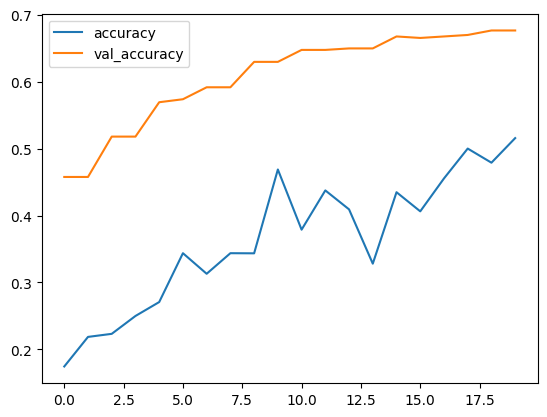

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend(); plt.show()

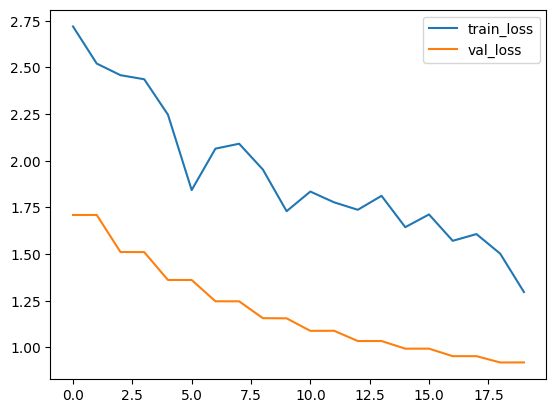

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.show()
